##### Date: 09/27/2021
##### Data Reference: KDD99 dataset (http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) 
##### Python library: pandas, numpy, seaborn, matplotlib, sklearn, imblearn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing,metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [2]:
options = dict(compression='gzip',header=None)
train_data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz',**options)
test_data = pd.read_csv('http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz',**options)
columns = train_data.columns

In [3]:
train_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
test_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.


In [5]:
train_data.shape, test_data.shape

((4898431, 42), (311029, 42))

In [6]:
t1 = train_data.copy()
t2 = test_data.copy()

In [7]:
train_data = t1.copy()
test_data = t2.copy()

In [8]:
'''
filter data to subset of balance train train
'''
dos_str = ['back.','neptune.','smurf.','teardrop.']
cond = train_data[41].str.contains('(?=.*back|neptune|smurf|teardrop)') # get all dos
print('counts of dos: ',cond.sum()) # dos is unbalance
print('counts of non-dos: ',train_data.shape[0]-cond.sum())
seed = 2
np.random.seed(seed) # fix random choice
nondos = np.random.choice(np.where(cond==1)[0],size=50000,replace=False) # randomly choice 30000 non-dos
dos = np.random.choice(np.where(cond==0)[0],size=50000,replace=False) # randomly choice 30000 dos
train_data = train_data.loc[np.concatenate((dos,nondos))] # make the dataset smaller
train_unique_target = train_data[41].unique() # get all unique targets from train dataset
test_unique_target = test_data[41].unique() # get all unique targets from test dataset
target_values = train_unique_target[np.in1d(train_unique_target,test_unique_target)] # common targets
train_data = train_data.loc[train_data[41].isin(target_values)] # filter train data
test_data = test_data.loc[test_data[41].isin(target_values)] # filter test data
train_data[45] = train_data[41].apply(lambda x: 1 if x in dos_str else 0) # turn targets into 0/1
test_data[45] = test_data[41].apply(lambda x: 1 if x in dos_str else 0) # turn targets into 0/1

test_data = (test_data.loc[~(test_data[2].isin(['tim_i','icmp','tftp_u']))&
                           ~(test_data[3].isin(['OTH']))]
                            .reset_index(drop=1)
                            .drop_duplicates())
'''
encode characters/words into numerical values
'''
encodes = []
for i in range(1,4):
    encodes.append(preprocessing.LabelEncoder())
    train_data[41+i] = encodes[i-1].fit_transform(train_data[i])
    test_data[41+i] = encodes[i-1].transform(test_data[i])

x_index=[0]+train_data.columns[4:41].tolist()+[42,43,44,45,1,2,3,41] # reorder columns
train_data = train_data[x_index].reset_index(drop=1).drop_duplicates()
test_data = test_data[x_index]
features = train_data.columns[:41] #all features columns total 40
'''
1. getting the train X and corresponding y and test X and corresponding y values

2. standardize all features

3. balance binary dataset
'''
rus = RandomUnderSampler(random_state=seed) # random balance sample function
standard = preprocessing.StandardScaler() # standardize data func
X_train,y_train = rus.fit_resample(standard.fit_transform(train_data[features].values),train_data[45])
X_test,y_test = standard.transform(test_data[features].values),test_data[45].values
total_size = y_train.shape[0]
dos_ = np.where(y_train==1)[0].shape[0]
print('='*80)
print('Total number of features: {}'.format(features.shape[0]))
print('='*80)
print('dos samples size: {} and non dos samples size:{}'.format(dos_,total_size-dos_))

counts of dos:  3883085
counts of non-dos:  1015346
Total number of features: 41
dos samples size: 11696 and non dos samples size:11696


In [9]:
C = 1.0  # SVM regularization parameter
max_iter=100000
models = [svm.LinearSVC(C=C,max_iter=max_iter),
          svm.SVC(kernel='linear', max_iter=max_iter,C=C),
          svm.SVC(kernel='rbf', gamma='auto',max_iter=max_iter,C=C),
          svm.SVC(kernel='poly', degree=15,gamma='auto',max_iter=max_iter,C=C),
          svm.SVC(kernel='sigmoid',gamma='auto',max_iter=max_iter,C=C)]
models = [clf.fit(X_train, y_train) for clf in models]

# title for the plots
titles = ['LinearSVC (linear kernel)',
          'SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 15) kernel',
          'SVC with sigmoid']

In [10]:
for i,clf in enumerate(models):
    print('='*60)
    print(f"|| {titles[i]}: \ttesting score: {np.round(clf.score(X_test, y_test)*100,2)}%")

|| LinearSVC (linear kernel): 	testing score: 99.5%
|| SVC with linear kernel: 	testing score: 99.49%
|| SVC with RBF kernel: 	testing score: 99.76%
|| SVC with polynomial (degree 15) kernel: 	testing score: 97.91%
|| SVC with sigmoid: 	testing score: 95.72%


###### Reference:
* https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
* https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py

1. Compare the results for each of the kernels:
* LinearSVC (linear kernel) and SVC with linear kernel have similar accuracy about 99% SVC with linear kernel looks better. Similarly, SVC with RBF kernel and sigmoid also have high accuracy about 98% by comparing to linear kernels that is not significantly differece. Unfortunately SVC with polynomial (degree 15) kernel has worst accuracy only 30%. Which is the worst case for all five cases
2. Discuss the pros and cons of using each of the kernels that you've chosen:
* LinearSVC (linear kernel) and SVC with linear kernel:
    * pros: can apply different regularization, higher accuracy and fast evaluation, linear classifier is relatively faster than non-linear classifier
    * cons: takes more iterations to converge
* SVC with RBF kernel:
    * pros: higher accuracy
    * cons: takes much longer to evaluate
* SVC with sigmoid:
    * pros: higher accuracy ad fast evaluation
    * cons: slightly worst than other models
* SVC with polynomial (degree 15) kernel:
    * pros: more accuracy than linear classifier in non-linear dataset
    * cons: takes much longer to evaluate
* Overall pros:
    * works really well with a clear margin of separation
    * is effective in high dimensional spaces
    * is effective in cases where the number of dimensions is greater than the number of samples
    * uses a subset of training points in the decision function (called support vectors), so it is also memory efficient
* Overall cons:
    * doesn't perform well when we have large data set because the required training time is higher
    * doesn’t perform very well, when the data set has more noise i.e. target classes are overlapping

|| LinearSVC (linear kernel): 	testing score: 97.87%
|| SVC with linear kernel: 	testing score: 97.82%
|| SVC with RBF kernel: 	testing score: 97.99%


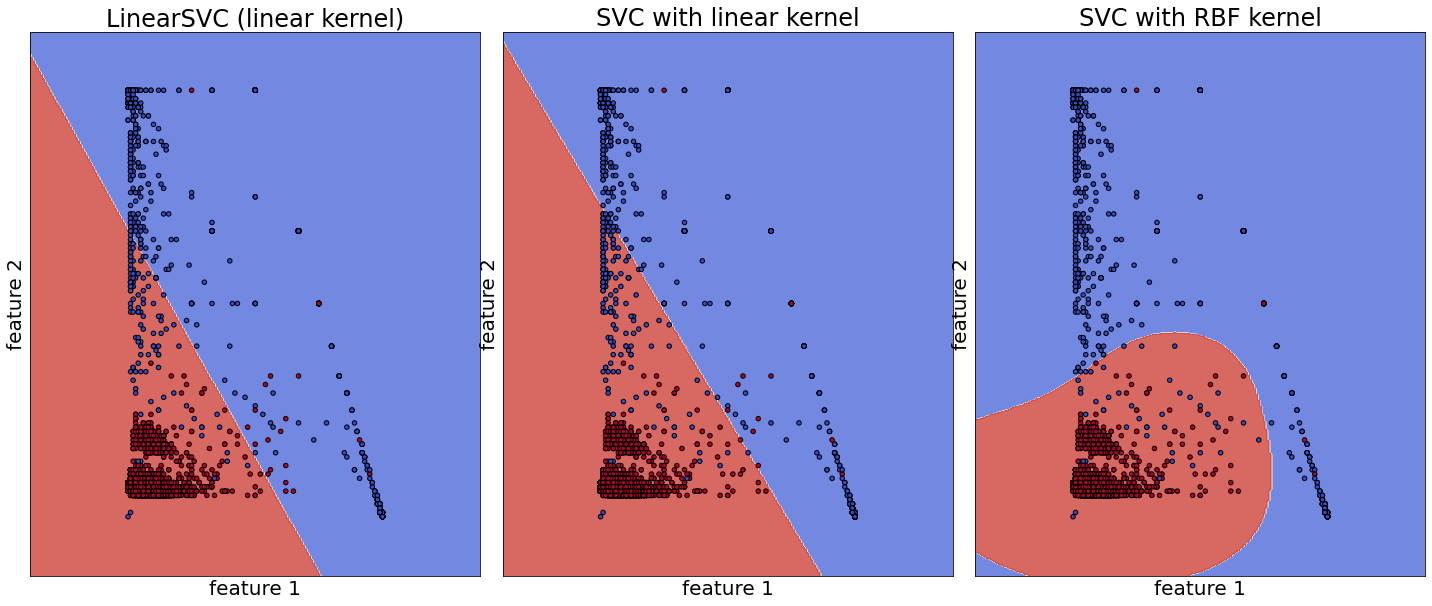

In [11]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

fselect = SelectKBest(mutual_info_classif,k=2) # feature selection
X_train_new = fselect.fit_transform(X_train, y_train) # select best 2 features for train
X_test_new = fselect.transform(X_test) # transform test
models = [svm.LinearSVC(C=C,max_iter=max_iter),
          svm.SVC(kernel='linear', max_iter=max_iter,C=C),
          svm.SVC(kernel='rbf', gamma='auto',max_iter=max_iter,C=C),]
models = [clf.fit(X_train_new, y_train) for clf in models]


# title for the plots
titles = ['LinearSVC (linear kernel)',
          'SVC with linear kernel',
          'SVC with RBF kernel']
for i,clf in enumerate(models):
    print('='*60)
    print(f"|| {titles[i]}: \ttesting score: {np.round(clf.score(X_test_new, y_test)*100,2)}%")


plt.rcParams.update({'font.size':20})
# Set-up 2x3 grid for plotting.
fig, axes = plt.subplots(1,3,figsize=(25,10))
axes = axes.flatten()
np.random.seed(seed)
X0, X1 = X_test_new[:, 0], X_test_new[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, axes):
    plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_test[:], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set(xlim=[xx.min(),xx.max()],xlabel='feature 1',xticks=(),
           ylim=[yy.min(),yy.max()],ylabel='feature 2',yticks=(),
           title=title)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

3. Pick two features which you think are important for this problem. Train SVM model using only those two features and visualize the decision boundary. Do this for linear kernel and RBF kernel only. You may want to subsample the training data substantially in order to get a good visualization within a reasonable time. Discuss your observations.
    * Base on the figure above, RBF kernel does a much better job than both linear classifiers, it separates two features in a well shape, on the other hand linear classifiers are able to separates most of the data but if they have two linear functions then they will do a better job similar to RBF. Overall, all model does a great job to separate two features and RBF has higher accuracy than both linear but not significantly.